# 读入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 999)

In [2]:
data = pd.read_csv('AmesHousing.txt', sep='\t')

train_raw = data.iloc[:1460]
test_raw = data.iloc[1460:]

train_subset = train_raw
train_subset.shape

(1460, 82)

# 主方程部分：

In [70]:
def transform_features(df):
    
    ### Dropping null values ###
    
    null_thd = len(df) / 2
    null_total = df.isnull().sum()
    for col in null_total.index:
        if null_total[col] > null_thd:
            df = df.drop(col, axis=1)
    
    
    ### Processing object columns ### 
    
    txt_train = df.select_dtypes(include=['object'])
            
    
    ### Processing numerical columns ###
    ## Variance values processing
    num_train = df.select_dtypes(include=['int', 'float'])
    num_var = num_train / num_train.max()
    var_series = num_var.var().sort_values()
    
    for col in var_series.index:
        if var_series[col] < 0.015:
            num_train = num_train.drop(col, axis=1)
    
    low_corr_cols = ['Order', 'Mo Sold', 'Bsmt Half Bath', 'MS SubClass','Bsmt Unf SF', 'PID']
    num_train = num_train.drop(low_corr_cols, axis=1)
    try:
        price = num_train[['SalePrice']]
    except:
        price = df[['SalePrice']]
        num_train = pd.concat([num_train, price], axis=1)

    return txt_train, num_train

In [71]:
def select_features(df):
    
    txt_train, num_train = transform_features(df)

    
    ### Tune your model here ###
    
    txt_train = df.select_dtypes(include=['object'])
    
    txt_useless = ['Sale Type', 'Sale Condition']
    txt_train = txt_train.drop(txt_useless, axis=1)
    
    for col in txt_train.columns:
        txt_train[col] = txt_train[col].astype('category')
        col_dummies = pd.get_dummies(txt_train[col], prefix=col)
        txt_train = pd.concat([txt_train, col_dummies], axis=1)
        del txt_train[col]

    
    num_cat = []
    for col in num_train.columns:
        val_counts = len(num_train[col].value_counts())
        if val_counts < 15:
            num_cat.append(col)
    
    for col in num_cat:
        num_train[col] = num_train[col].astype('category')
        col_dummies = pd.get_dummies(num_train[col], prefix=col)
        num_train = pd.concat([num_train, col_dummies], axis=1)
        del num_train[col]

    num_train = num_train.fillna(num_train.mean())

    ### Turn your model here ###
    
    
    train_clean = pd.concat([txt_train, num_train], axis=1)
    return train_clean

In [72]:
def train_and_test(df):
    data_sets = select_features(df)

    train_set = data_sets.drop('SalePrice', axis=1)
    target_set = data_sets[['SalePrice']]
    
    kf = KFold(5, shuffle=True, random_state=1)
    model = LinearRegression()
    
    mses = cross_val_score(model, train_set, target_set,
                           scoring='neg_mean_absolute_error', cv=kf)
    rmses = [np.sqrt(np.abs(mse)) for mse in mses]
    avg_rmse = sum(rmses)/len(rmses)
    return rmses, avg_rmse

cross_check_rmse, cross_avg_rmse = train_and_test(data)
print('***************************')
print('RMSEs for cross check is:', cross_check_rmse)
print('***************************')
print('Overall average RMSE from cross check is:', cross_avg_rmse)

***************************
RMSEs for cross check is: [135.48797561725394, 140.88906580761858, 141.7382703887271, 136.86448079637049, 138.74976477673684]
***************************
Overall average RMSE from cross check is: 138.745911477


### 对数据进行初步处理后结果如上方所示

## 下一步针对剩下的feature进行筛选，尝试进一步减小误差

In [35]:
txt_df, num_df = transform_features(data)
num_df = num_df.fillna(num_df.mean())

### 数字部分：

In [36]:
print(num_df.shape, '\n')
print(num_df.columns)

(2930, 16) 

Index(['Order', 'PID', 'MS SubClass', 'Overall Qual', 'Overall Cond',
       'Bsmt Unf SF', '2nd Flr SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Fireplaces', 'Garage Cars', 'Garage Area',
       'Mo Sold', 'SalePrice'],
      dtype='object')


In [37]:
corrmat = num_df.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

Order             0.031408
Mo Sold           0.035259
Bsmt Half Bath    0.035815
MS SubClass       0.085092
Overall Cond      0.101697
Bsmt Unf SF       0.182805
PID               0.246521
2nd Flr SF        0.269373
Bsmt Full Bath    0.275894
Half Bath         0.285056
Fireplaces        0.474558
Full Bath         0.545604
Garage Area       0.640385
Garage Cars       0.647861
Overall Qual      0.799262
SalePrice         1.000000
Name: SalePrice, dtype: float64


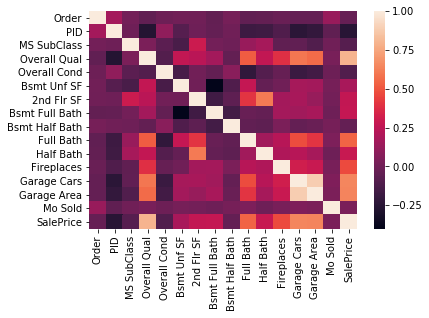

In [38]:
%matplotlib inline
sns.heatmap(corrmat)

In [54]:
low_corr_cols = sorted_corrs[sorted_corrs < 0.3].index
num_clean = num_df.drop(low_corr_cols, axis=1)
print(low_corr_cols)

Index(['Order', 'Mo Sold', 'Bsmt Half Bath', 'MS SubClass', 'Overall Cond',
       'Bsmt Unf SF', 'PID', '2nd Flr SF', 'Bsmt Full Bath', 'Half Bath'],
      dtype='object')


### 文字部分：

In [40]:
print(txt_df.shape, '\n')
print(txt_df.columns)

(2930, 39) 

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition'],
      dtype='object')


In [46]:
for col in txt_df.columns:
    val_counts = len(txt_df[col].value_counts())
    print(col, ':\t', val_counts)

MS Zoning :	 7
Street :	 2
Lot Shape :	 4
Land Contour :	 4
Utilities :	 3
Lot Config :	 5
Land Slope :	 3
Neighborhood :	 28
Condition 1 :	 9
Condition 2 :	 8
Bldg Type :	 5
House Style :	 8
Roof Style :	 6
Roof Matl :	 8
Exterior 1st :	 16
Exterior 2nd :	 17
Mas Vnr Type :	 5
Exter Qual :	 4
Exter Cond :	 5
Foundation :	 6
Bsmt Qual :	 5
Bsmt Cond :	 5
Bsmt Exposure :	 4
BsmtFin Type 1 :	 6
BsmtFin Type 2 :	 6
Heating :	 6
Heating QC :	 5
Central Air :	 2
Electrical :	 5
Kitchen Qual :	 5
Functional :	 8
Fireplace Qu :	 5
Garage Type :	 6
Garage Finish :	 3
Garage Qual :	 5
Garage Cond :	 5
Paved Drive :	 3
Sale Type :	 10
Sale Condition :	 6


# 实验测试部分：

### 处理null value

In [29]:
null_thd = len(train_subset) / 2
null_total = train_subset.isnull().sum()

print('null门限设置为数据集长度一半：', null_thd)

for col in null_total.index:
    if null_total[col] > null_thd:
        train_subset = train_subset.drop(col, axis=1)
    
print('处理后数据集中null最多的有：', train_subset.isnull().sum().sort_values().max())

null门限设置为数据集长度一半： 730.0
处理后数据集中null最多的有： 717


### 删除数字部分变化率很小的列

In [30]:
num_train = train_subset.select_dtypes(include=['int', 'float'])
num_var = num_train / num_train.max()
var_series = num_var.var().sort_values()

for col in var_series.index:
    if var_series[col] < 0.015:
        num_train = num_train.drop(col, axis=1)
        var_series = var_series.drop(col)
print(var_series.apply(lambda x: '%.8f' %x))

SalePrice         0.01624368
Overall Cond      0.01650477
Total Bsmt SF     0.01784242
Gr Liv Area       0.01801363
Mas Vnr Area      0.01843943
Full Bath         0.01862096
Enclosed Porch    0.01897504
Bedroom AbvGr     0.01914872
1st Flr SF        0.01918180
Overall Qual      0.01984168
Garage Area       0.02034663
Garage Cars       0.02258398
Bsmt Full Bath    0.03130948
Wood Deck SF      0.03306444
Bsmt Unf SF       0.03393995
BsmtFin SF 1      0.03760276
PID               0.04093864
Fireplaces        0.04658948
Mo Sold           0.04896651
MS SubClass       0.04991815
Bsmt Half Bath    0.05308050
2nd Flr SF        0.05362407
Half Bath         0.06471359
Order             0.08339041
dtype: object


In [44]:
num_test = num_train
for col in num_test.columns:
    print(col)
    val_counts = len(num_test[col].value_counts())
    print(val_counts)

Order
1460
PID
1460
MS SubClass
15
Overall Qual
10
Overall Cond
9
Mas Vnr Area
304
BsmtFin SF 1
668
Bsmt Unf SF
767
Total Bsmt SF
728
1st Flr SF
764
2nd Flr SF
405
Gr Liv Area
880
Bsmt Full Bath
4
Bsmt Half Bath
2
Full Bath
5
Half Bath
3
Bedroom AbvGr
7
Fireplaces
4
Garage Cars
6
Garage Area
442
Wood Deck SF
272
Enclosed Porch
132
Mo Sold
12
SalePrice
644


In [31]:
num_clean = num_train
num_cat = ['Full Bath', 'Bedroom AbvGr', 'Overall Qual', 'Garage Cars', 'Bsmt Full Bath',
          'Fireplaces', 'MS SubClass', 'Bsmt Half Bath', 'Half Bath']


num_useless = ['PID', 'Mo Sold', 'Order']

for col in num_cat:
    num_clean[col] = num_clean[col].astype('category')
    col_dummies = pd.get_dummies(num_clean[col], prefix=col)
    num_clean = pd.concat([num_clean, col_dummies], axis=1)
    del num_clean[col]
for col in num_useless:
    del num_clean[col]

num_clean = num_clean.fillna(num_clean.mean())
print(num_clean.columns)

Index(['Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Garage Area', 'Wood Deck SF', 'Enclosed Porch', 'SalePrice',
       'Full Bath_0', 'Full Bath_1', 'Full Bath_2', 'Full Bath_3',
       'Full Bath_4', 'Bedroom AbvGr_0', 'Bedroom AbvGr_1', 'Bedroom AbvGr_2',
       'Bedroom AbvGr_3', 'Bedroom AbvGr_4', 'Bedroom AbvGr_5',
       'Bedroom AbvGr_6', 'Overall Qual_1', 'Overall Qual_2', 'Overall Qual_3',
       'Overall Qual_4', 'Overall Qual_5', 'Overall Qual_6', 'Overall Qual_7',
       'Overall Qual_8', 'Overall Qual_9', 'Overall Qual_10',
       'Garage Cars_0.0', 'Garage Cars_1.0', 'Garage Cars_2.0',
       'Garage Cars_3.0', 'Garage Cars_4.0', 'Garage Cars_5.0',
       'Bsmt Full Bath_0.0', 'Bsmt Full Bath_1.0', 'Bsmt Full Bath_2.0',
       'Bsmt Full Bath_3.0', 'Fireplaces_0', 'Fireplaces_1', 'Fireplaces_2',
       'Fireplaces_3', 'MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40',
       '

In [32]:
txt_train = train_subset.select_dtypes(include=['object'])

for col in txt_train.columns:
    txt_train[col] = txt_train[col].astype('category')
    col_dummies = pd.get_dummies(txt_train[col], prefix=col)
    txt_train = pd.concat([txt_train, col_dummies], axis=1)
    del txt_train[col]
print(txt_train.columns)

Index(['MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)',
       'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM', 'Street_Grvl',
       'Street_Pave', 'Lot Shape_IR1', 'Lot Shape_IR2',
       ...
       'Sale Type_ConLI', 'Sale Type_ConLw', 'Sale Type_New', 'Sale Type_Oth',
       'Sale Type_WD ', 'Sale Condition_Abnorml', 'Sale Condition_Alloca',
       'Sale Condition_Family', 'Sale Condition_Normal',
       'Sale Condition_Partial'],
      dtype='object', length=235)


/Users/gangwanfang/anaconda/envs/dataquest/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
train_clean = pd.concat([num_clean, txt_train], axis=1)
print(train_clean.columns)

Index(['Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Garage Area', 'Wood Deck SF',
       ...
       'Sale Type_ConLI', 'Sale Type_ConLw', 'Sale Type_New', 'Sale Type_Oth',
       'Sale Type_WD ', 'Sale Condition_Abnorml', 'Sale Condition_Alloca',
       'Sale Condition_Family', 'Sale Condition_Normal',
       'Sale Condition_Partial'],
      dtype='object', length=303)


In [34]:
train_clean.isnull().sum().sort_values()

Overall Cond              0
Foundation_PConc          0
Foundation_CBlock         0
Foundation_BrkTil         0
Exter Cond_TA             0
Exter Cond_Po             0
Exter Cond_Gd             0
Exter Cond_Fa             0
Exter Cond_Ex             0
Exter Qual_TA             0
Exter Qual_Gd             0
Exter Qual_Fa             0
Exter Qual_Ex             0
Mas Vnr Type_Stone        0
Mas Vnr Type_None         0
Mas Vnr Type_BrkFace      0
Foundation_Slab           0
Mas Vnr Type_BrkCmn       0
Foundation_Stone          0
Bsmt Qual_Ex              0
BsmtFin Type 1_GLQ        0
BsmtFin Type 1_BLQ        0
BsmtFin Type 1_ALQ        0
Bsmt Exposure_No          0
Bsmt Exposure_Mn          0
Bsmt Exposure_Gd          0
Bsmt Exposure_Av          0
Bsmt Cond_TA              0
Bsmt Cond_Po              0
Bsmt Cond_Gd              0
Bsmt Cond_Fa              0
Bsmt Cond_Ex              0
Bsmt Qual_TA              0
Bsmt Qual_Gd              0
Bsmt Qual_Fa              0
Foundation_Wood     

In [35]:
def transform_features():
    train = train_clean
    return train

In [36]:
def select_features():
    train = transform_features()
    return train

In [37]:
def train_and_test():
    df = select_features()
    train_set = df.drop('SalePrice', axis=1)
    target_set = df[['SalePrice']]
    
    kf = KFold(5, shuffle=True, random_state=1)
    model = LinearRegression()
    
    mses = cross_val_score(model, train_set, target_set,
                           scoring='neg_mean_absolute_error', cv=kf)
    rmses = [np.sqrt(np.abs(mse)) for mse in mses]
    avg_rmse = sum(rmses)/len(rmses)
    return rmses, avg_rmse

result = train_and_test()
print(result)

([130.01711360170518, 128.13745725503492, 131.82251321443897, 128.99407414408796, 132.35492438716665], 130.26521652048672)
